## Exploratory Data Analysis of our imputed mushroom dataset
* Run Cramers V to get an indication of dependency of columns with target column
* Make some graphs to get a better idea of dataset



In [1]:
# import packages

import numpy as np
import pandas as pd
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import klib
import plotly.figure_factory as ff
from IPython.core.display import display
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import joblib
# pd.set_option('display.max_columns', None)
# pd.reset_option('max_rows')
#np.set_printoptions(threshold=sys.maxsize)

plt.style.use('dark_background')
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
sns.set(style='ticks', context='talk')

In [2]:
# useful functions
def get_adjusted_cramers_v(contingency_table):
    """ variation of cramers v that adjusts for bias
    via using a smaller mean-squared error.
    It calculates and returns this statistic"""

    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    number_of_obs = np.sum(contingency_table).sum()
    phi2 = chi2 / number_of_obs
    phi2_adjusted = max(0, phi2 - dof/(number_of_obs-1))
    row, column = contingency_table.shape
    row_adjusted = row - ((row-1)**2)/(number_of_obs-1)
    column_adjusted = column - ((column-1)**2)/(number_of_obs-1)
    mini_adjusted = min(row_adjusted, column_adjusted)-1

    cramers_v_adjusted = np.sqrt(phi2_adjusted / mini_adjusted)
    return cramers_v_adjusted


In [3]:
path = r'../../data/processed/mushroom_imputed_2.csv'

mushroom = pd.read_csv(path)
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,smooth,white,white,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,smooth,white,white,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,smooth,white,white,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,smooth,white,white,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,no,none,free,crowded,broad,black,...,smooth,smooth,white,white,white,one,evanescent,brown,abundant,grasses


In [4]:
mushroom.shape, mushroom.isnull().sum()

((8112, 22),
 class                       0
 cap-shape                   0
 cap-surface                 0
 cap-color                   0
 bruises                     0
 odor                        0
 gill-attachment             0
 gill-spacing                0
 gill-size                   0
 gill-color                  0
 stalk-shape                 0
 stalk-root                  0
 stalk-surface-above-ring    0
 stalk-surface-below-ring    0
 stalk-color-above-ring      0
 stalk-color-below-ring      0
 veil-color                  0
 ring-number                 0
 ring-type                   0
 spore-print-color           0
 population                  0
 habitat                     0
 dtype: int64)

Quick check to see our size; and corrected that we have no missing values at all

Also want to capitalize all columns of the mushroom features

In [5]:
display(mushroom.iloc[:, :7].describe(include='O'))
display(mushroom.iloc[:, 7:14].describe(include='O'))
display(mushroom.iloc[:, 14:].describe(include='O'))

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment
count,8112,8112,8112,8112,8112,8112,8112
unique,2,6,4,10,2,9,2
top,edible,convex,scaly,brown,no,none,free
freq,4196,3650,3244,2282,4736,3516,7904


,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring
count,8112,8112,8112,8112,8112,8112,8112
unique,2,2,12,2,4,4,4
top,close,broad,buff,tapering,bulbous,smooth,smooth
freq,6810,5600,1728,4608,5806,5169,4929


,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8112,8112,8112,8112,8112,8112,8112,8112
unique,9,9,4,3,5,9,6,7
top,white,white,white,one,pendant,white,several,woods
freq,4454,4374,7914,7486,3956,2378,4040,3148


Illustrate the number of unique attriubtes for each category, and the top number of features with frequency of that value


Text(0.5, 1.0, 'Distribution of Edible and Poisonous mushrooms for our dataset')

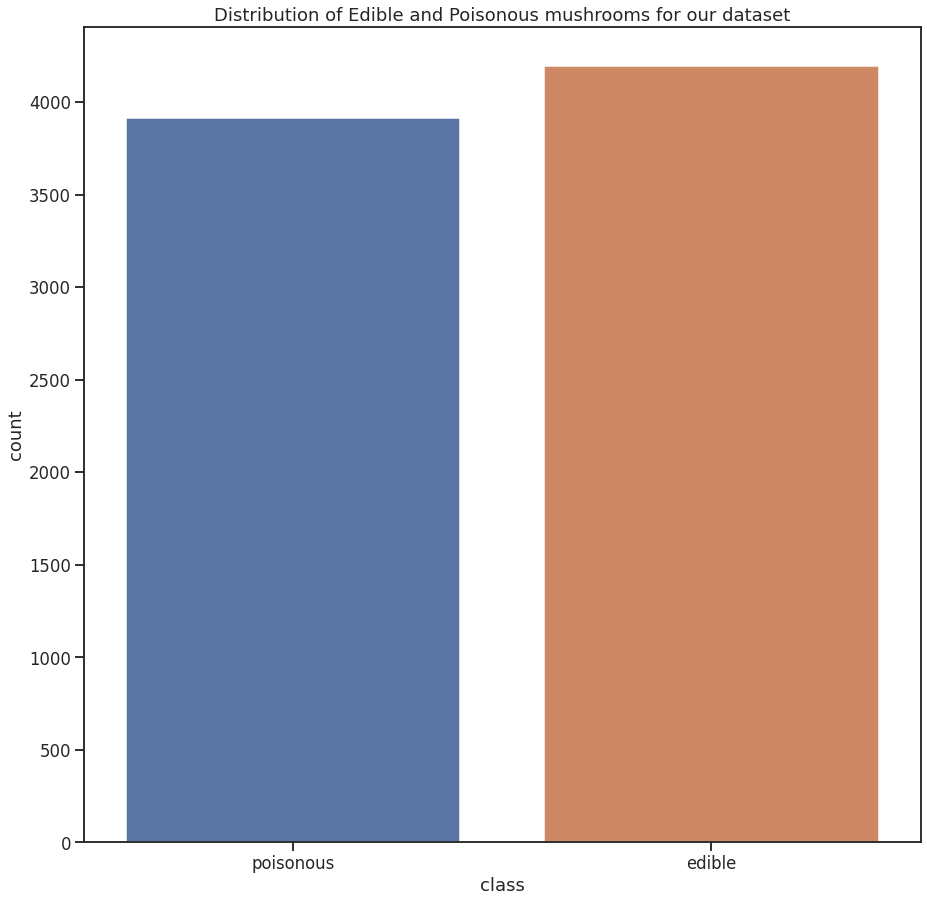

In [6]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, x='class')
plt.title("Distribution of Edible and Poisonous mushrooms for our dataset")

This is just used to show that our target distribution is relatively balanced

In [7]:
mush_col = mushroom.columns.tolist()
for count, col in enumerate(mush_col):
    mush_col[count] = mush_col[count].title()

mushroom.columns = mush_col
mushroom.columns

Index(['Class', 'Cap-Shape', 'Cap-Surface', 'Cap-Color', 'Bruises', 'Odor',
       'Gill-Attachment', 'Gill-Spacing', 'Gill-Size', 'Gill-Color',
       'Stalk-Shape', 'Stalk-Root', 'Stalk-Surface-Above-Ring',
       'Stalk-Surface-Below-Ring', 'Stalk-Color-Above-Ring',
       'Stalk-Color-Below-Ring', 'Veil-Color', 'Ring-Number', 'Ring-Type',
       'Spore-Print-Color', 'Population', 'Habitat'],
      dtype='object')

In [8]:
# save this adjusted column naming
path_csv = r'../../data/processed/mushroom_imputed_2_adj.csv'
mushroom.to_csv(path_csv, index=False)

In [9]:
mush_col = mushroom.drop('Class', axis=1).columns.tolist()

adj_cramers_v_values = []
for col in mush_col:
   contingency_table = pd.crosstab(mushroom['Class'], mushroom[col])
   adj_cramers_v_values.append(get_adjusted_cramers_v(contingency_table))

In [10]:
# get associated strengths for more interpretatbilitty
assoc_strengths = ['Strong', 'Moderate', 'Weak', 'Very weak']

assoc_strengths_values = [assoc_strengths[0] if val > 0.5 else
                          assoc_strengths[1] if val > 0.3 else
                          assoc_strengths[2] if val > 0.1 else
                          assoc_strengths[3] for val in adj_cramers_v_values]

In [11]:
relation_df = pd.DataFrame({'Mushroom Features':mush_col,
                            'Adjusted Cramers V':adj_cramers_v_values,
                            'Association Strength': assoc_strengths_values}).sort_values(by='Adjusted Cramers V', ascending=False)
relation_df.reset_index(drop=True, inplace=True)
relation_df

,Mushroom Features,Adjusted Cramers V,Association Strength
0,Odor,0.970520,Strong
1,Spore-Print-Color,0.753543,Strong
2,Gill-Color,0.680438,Strong
3,Ring-Type,0.602381,Strong
4,Stalk-Surface-Above-Ring,0.589013,Strong
5,Stalk-Surface-Below-Ring,0.575930,Strong
6,Gill-Size,0.539272,Strong
7,Stalk-Color-Above-Ring,0.523683,Strong
8,Stalk-Color-Below-Ring,0.513519,Strong
9,Bruises,0.503003,Strong


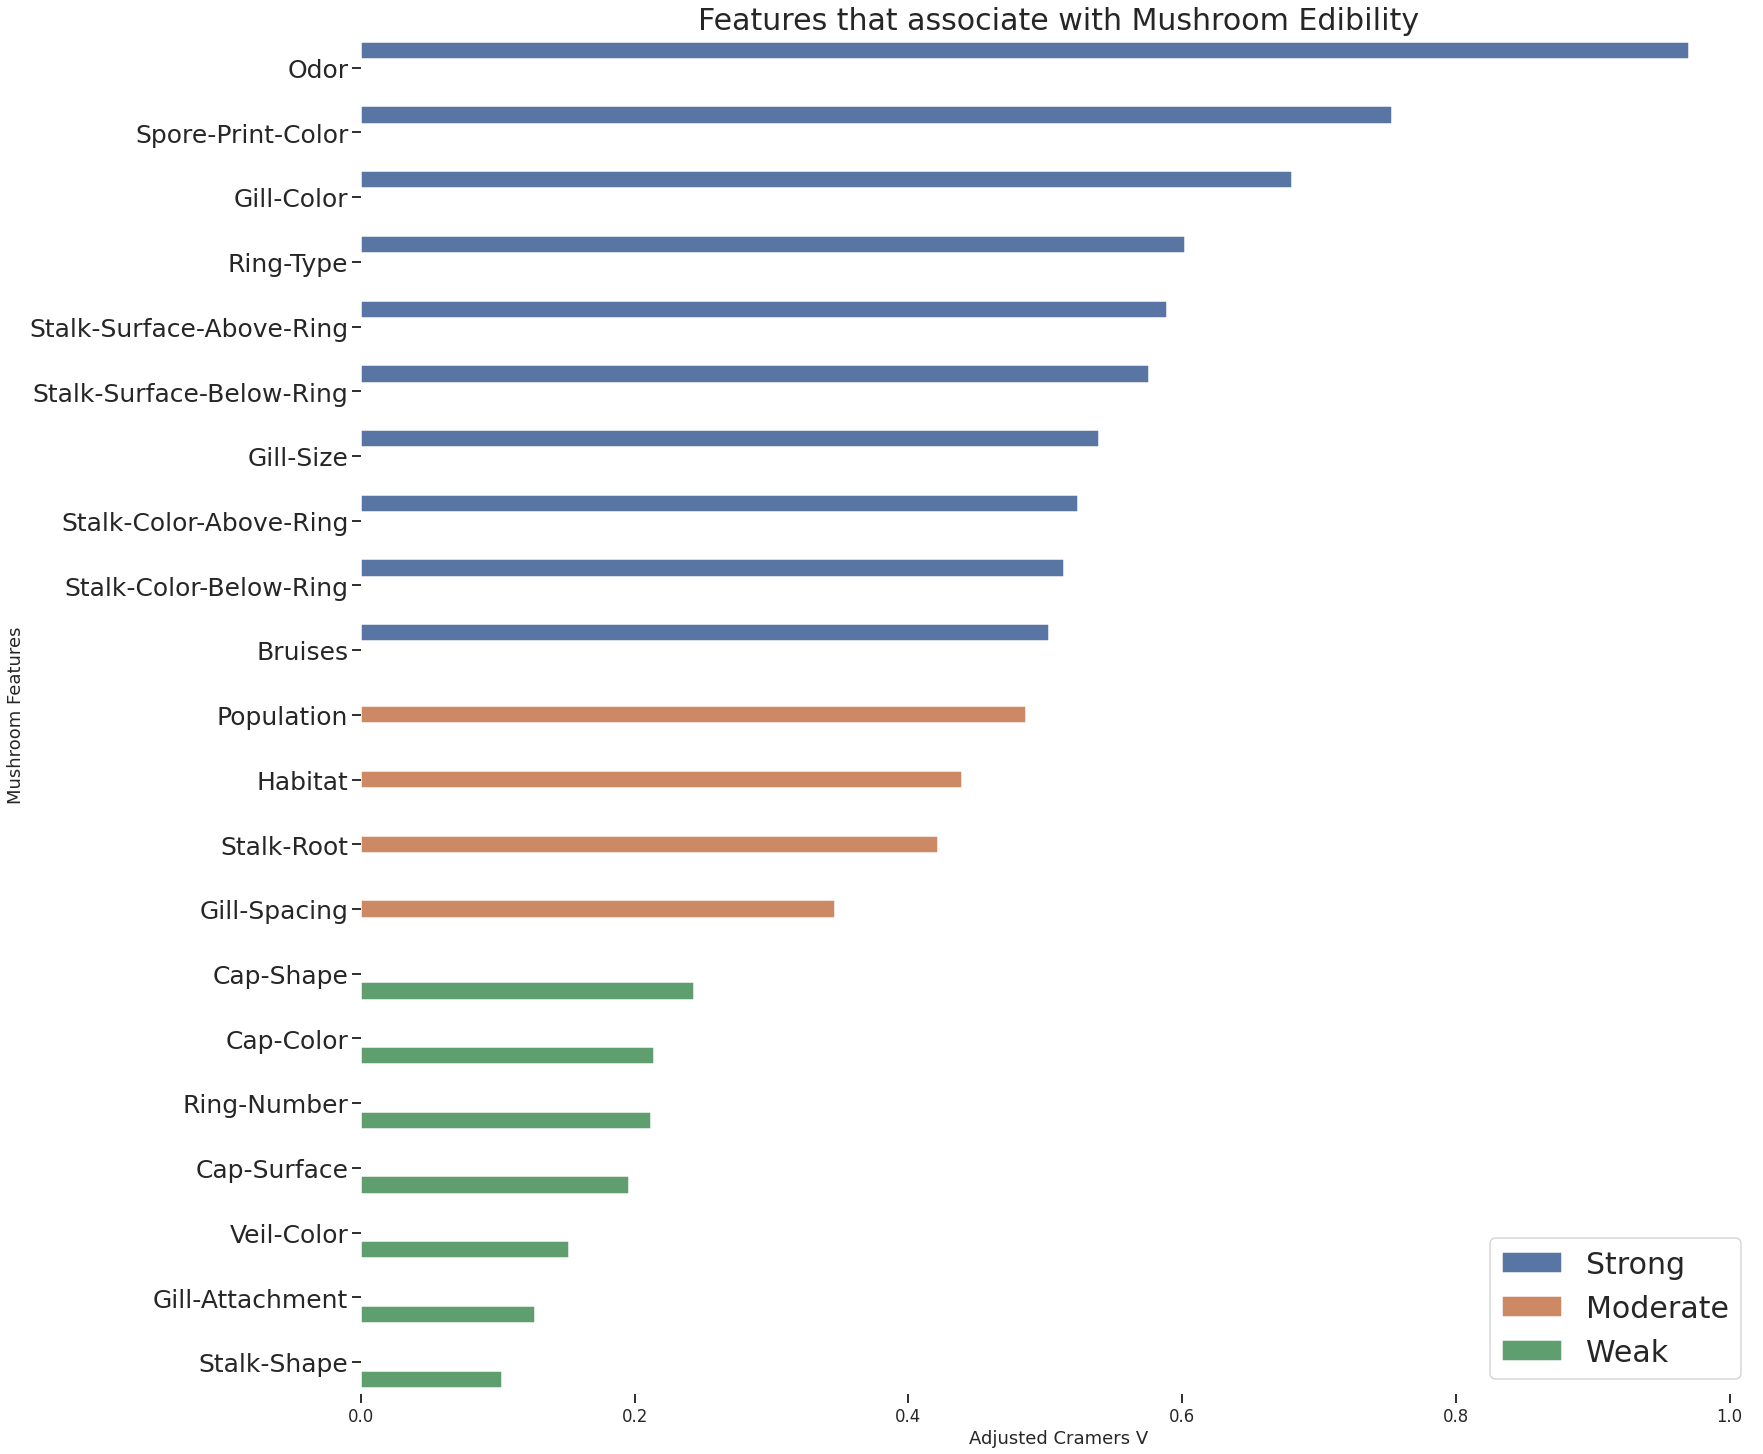

In [12]:
plt.figure(figsize=(25,25))
sns.barplot(data=relation_df, y='Mushroom Features', x='Adjusted Cramers V', hue='Association Strength')
sns.despine(left=True, bottom=True)
plt.title('Features that associate with Mushroom Edibility', fontsize=30)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)

The strongest indicators for edibility of mushroom should be the
odor, spore-print color, gill color, ring type, gill size, bruising, and other stalk-color around the rings

Surprisingly habitat, veil color, cap color, and stalk shape were weak indicators for edibility

In [13]:
# look at the docs and draw more graphs
# also ask more questions about dataset
for col in mush_col:
    print(col, mushroom[col].unique())

Cap-Shape ['convex' 'bell' 'sunken' 'flat' 'knobbed' 'conical']
Cap-Surface ['smooth' 'scaly' 'fibrous' 'grooves']
Cap-Color ['brown' 'yellow' 'white' 'gray' 'red' 'pink' 'buff' 'cinnamon' 'purple'
 'green']
Bruises ['bruises' 'no']
Odor ['pungent' 'almond' 'anise' 'none' 'foul' 'creosote' 'musty' 'fishy'
 'spicy']
Gill-Attachment ['free' 'attached']
Gill-Spacing ['close' 'crowded']
Gill-Size ['narrow' 'broad']
Gill-Color ['black' 'brown' 'gray' 'pink' 'white' 'chocolate' 'purple' 'green'
 'yellow' 'red' 'buff' 'orange']
Stalk-Shape ['enlarging' 'tapering']
Stalk-Root ['equal' 'club' 'bulbous' 'rooted']
Stalk-Surface-Above-Ring ['smooth' 'fibrous' 'silky' 'scaly']
Stalk-Surface-Below-Ring ['smooth' 'fibrous' 'scaly' 'silky']
Stalk-Color-Above-Ring ['white' 'gray' 'pink' 'brown' 'buff' 'cinnamon' 'yellow' 'red' 'orange']
Stalk-Color-Below-Ring ['white' 'pink' 'gray' 'buff' 'brown' 'cinnamon' 'yellow' 'red' 'orange']
Veil-Color ['white' 'yellow' 'brown' 'orange']
Ring-Number ['one' 'two'

# Extra Visualizations
* count plots for poionsonouse and top cramers v features


Text(0.5, 1.0, "If it's Scentless, it's most likely edible")

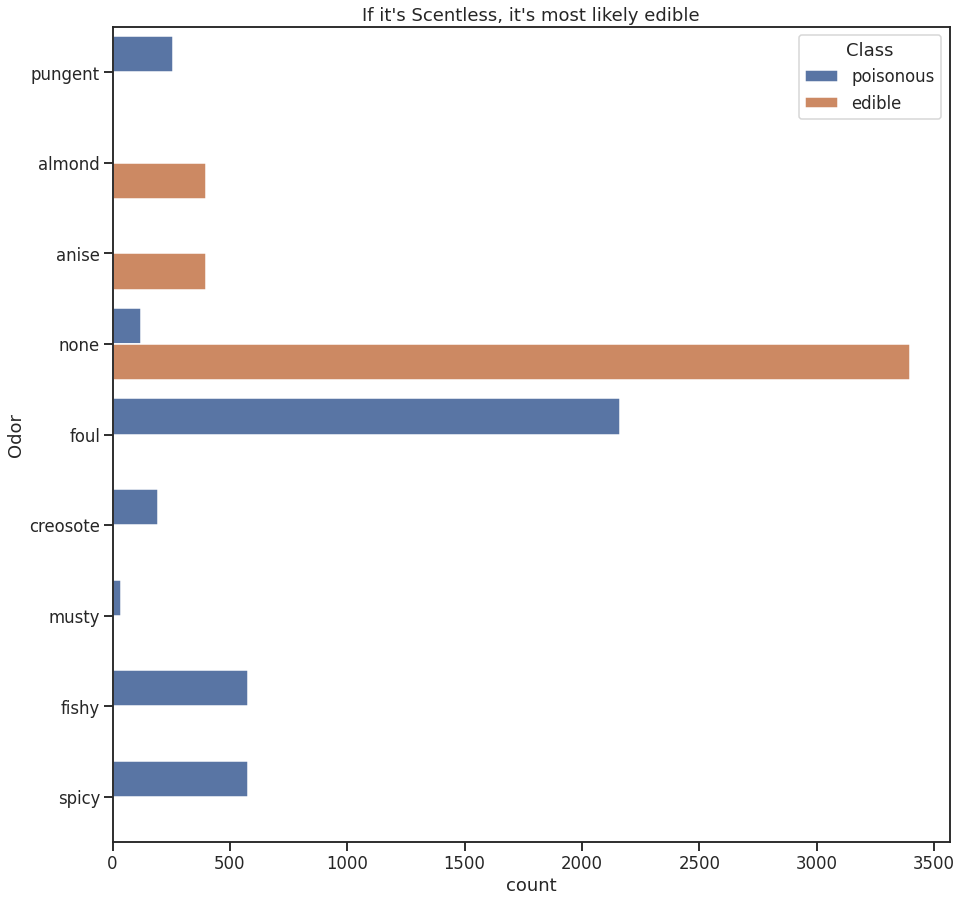

In [14]:
# do by odor
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Odor', hue='Class')
plt.title("If it's Scentless, it's most likely edible")

Basically this is saying that almond, anise, or have no odor, it is most likely edible
else other smells like spicy, fishy, musty, pungent, foul, creosote (smoky or like tar) means its poisonous
This is only for this dataset, once again not so confident on source of data

In [15]:
# see percentages
odor_edible = pd.crosstab(mushroom['Class'], mushroom['Odor'], normalize='columns')
odor_edible

Odor,almond,anise,creosote,fishy,foul,musty,none,pungent,spicy
Class,,,,,,,,,
edible,1.0,1.0,0.0,0.0,0.0,0.0,0.96587,0.0,0.0
poisonous,0.0,0.0,1.0,1.0,1.0,1.0,0.03413,1.0,1.0


* Data set does not tell much
* Mainly as we can see fromt he cross tab most of results are binary or show that mushrooms have no smell will  be edible
* If mushroom smells like something probably most likely poisonous
* We need an updated dataset for this
* Also little variation between the two classes

Text(0.5, 1.0, 'Beware Of Chocolate, White, Green, Black (Spore Prints)')

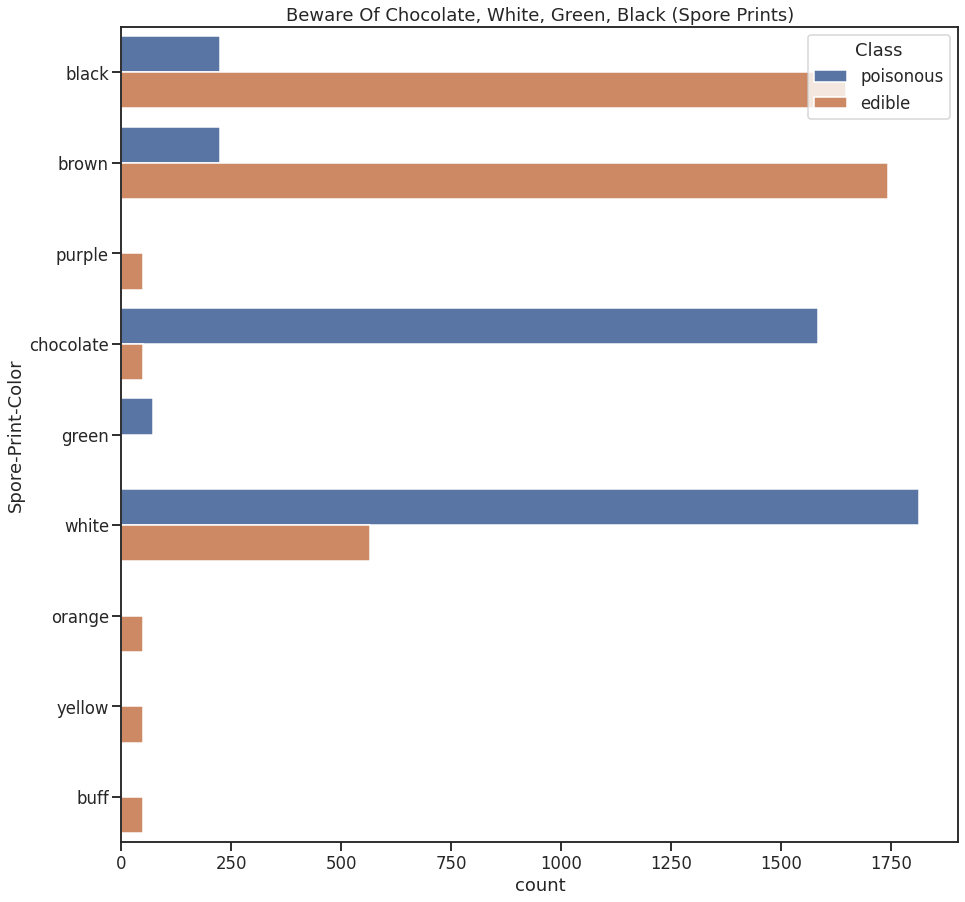

In [16]:

# do by spore print color
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Spore-Print-Color', hue='Class')
plt.title("Beware Of Chocolate, White, Green, Black (Spore Prints)")

* Once again wish there was more variety among colors
* but this points that most black, brown, and purple prints seem fine
* Question what poison means in this case as purple color which is common in psychedlic mushrooms, but I guess they label those as not poisonous
* I wish this dataset also linked the mushroom as well

In [17]:
spore_color_edible = pd.crosstab(mushroom['Class'], mushroom['Spore-Print-Color'], margins=True, normalize='columns')
spore_color_edible

Spore-Print-Color,black,brown,buff,chocolate,green,orange,purple,white,yellow,All
Class,,,,,,,,,,
edible,0.880342,0.886063,1.0,0.029412,0.0,1.0,1.0,0.238015,1.0,0.517258
poisonous,0.119658,0.113937,0.0,0.970588,1.0,0.0,0.0,0.761985,0.0,0.482742


Text(0.5, 1.0, 'Beware Of Buff, Chocolate, Green (Gill Color)')

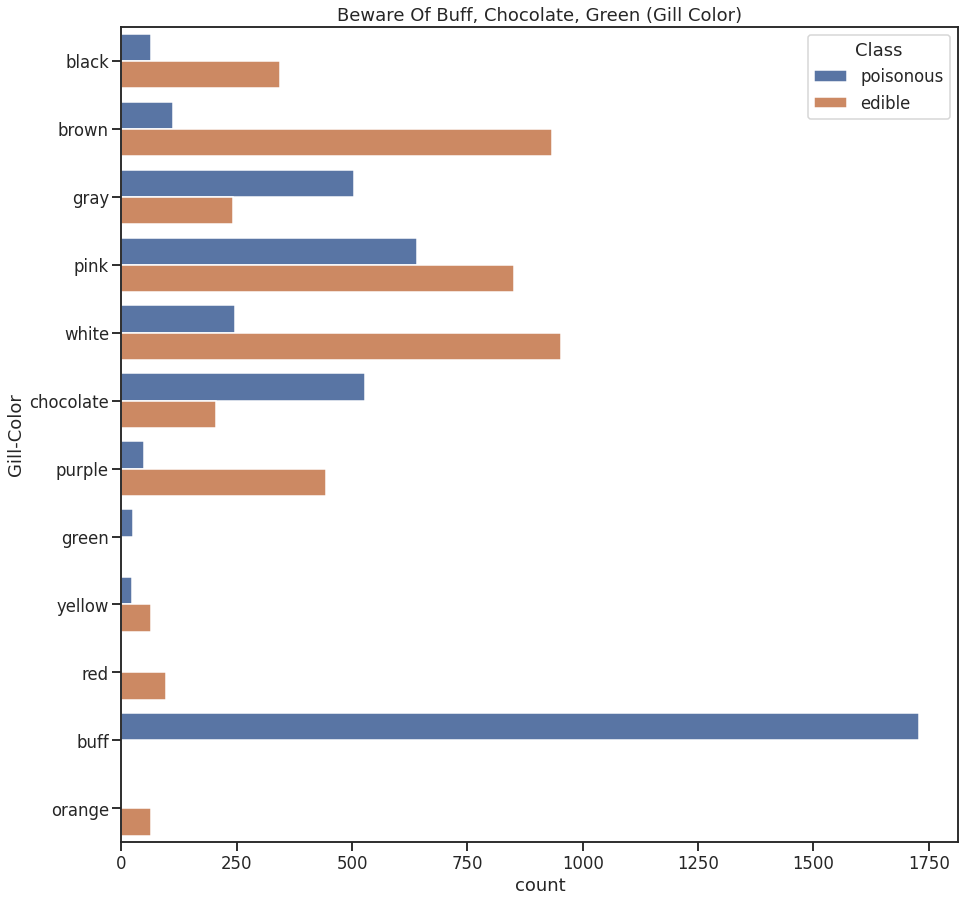

In [18]:
# see gill bruising stalk
# do by spore print color
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Gill-Color', hue='Class')
plt.title("Beware Of Buff, Chocolate, Green (Gill Color)")

So it seems that Orange is okay and higher chance of brown, black and purple being edible

Text(0.5, 1.0, 'Eat Broad, avoid Narrow (Gill Size)')

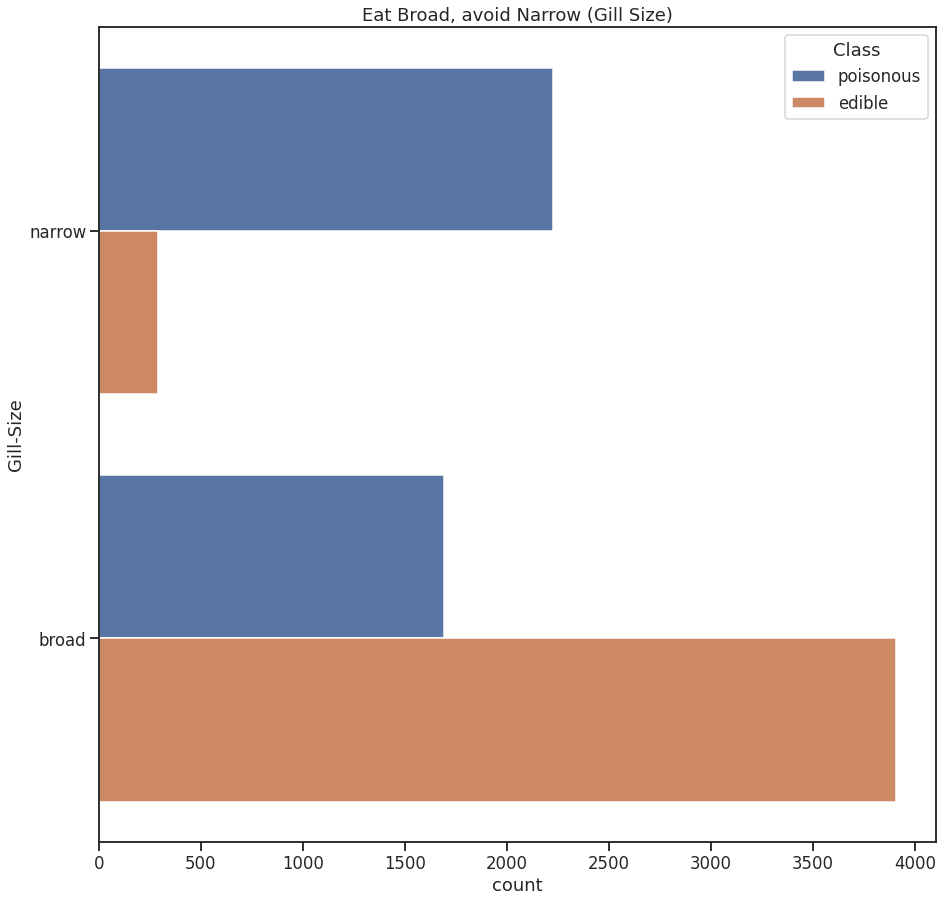

In [19]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Gill-Size', hue='Class')
plt.title("Eat Broad, avoid Narrow (Gill Size)")



Text(0.5, 1.0, 'Edible Bruising (Bruises)')

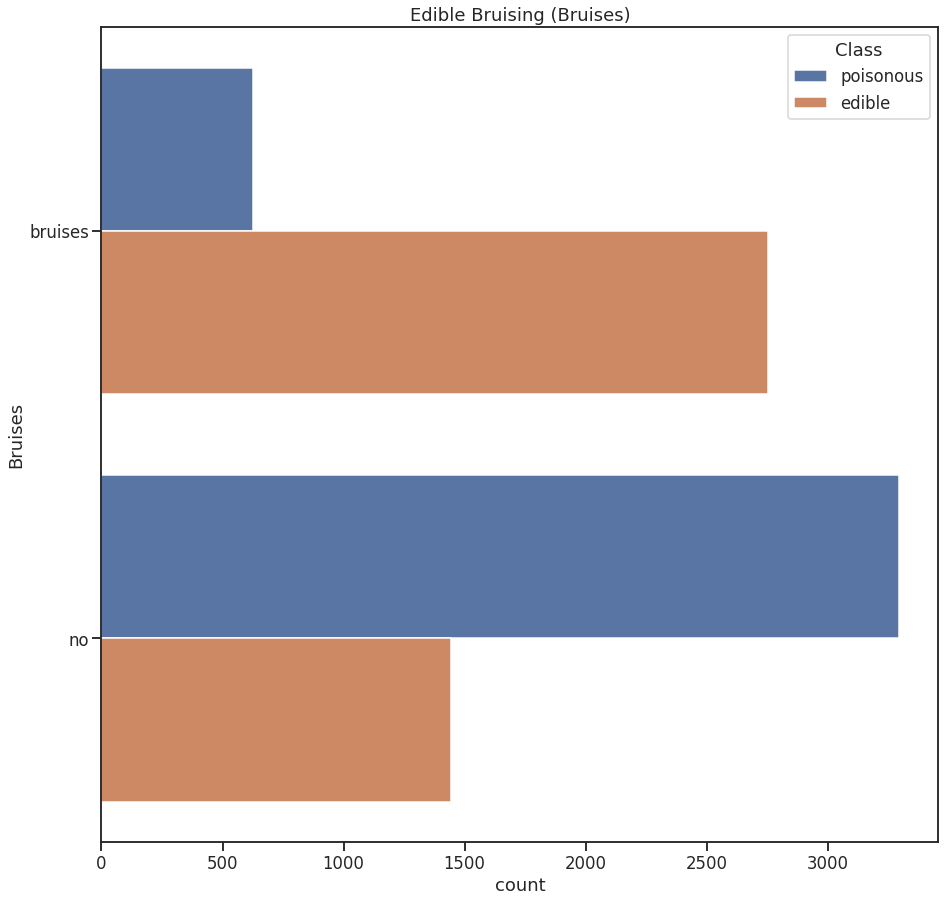

In [20]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Bruises', hue='Class')
plt.title("Edible Bruising (Bruises)")

Text(0.5, 1.0, 'We want it smooth and fibrous but not Silky (Stalk Surface-Above Ring)')

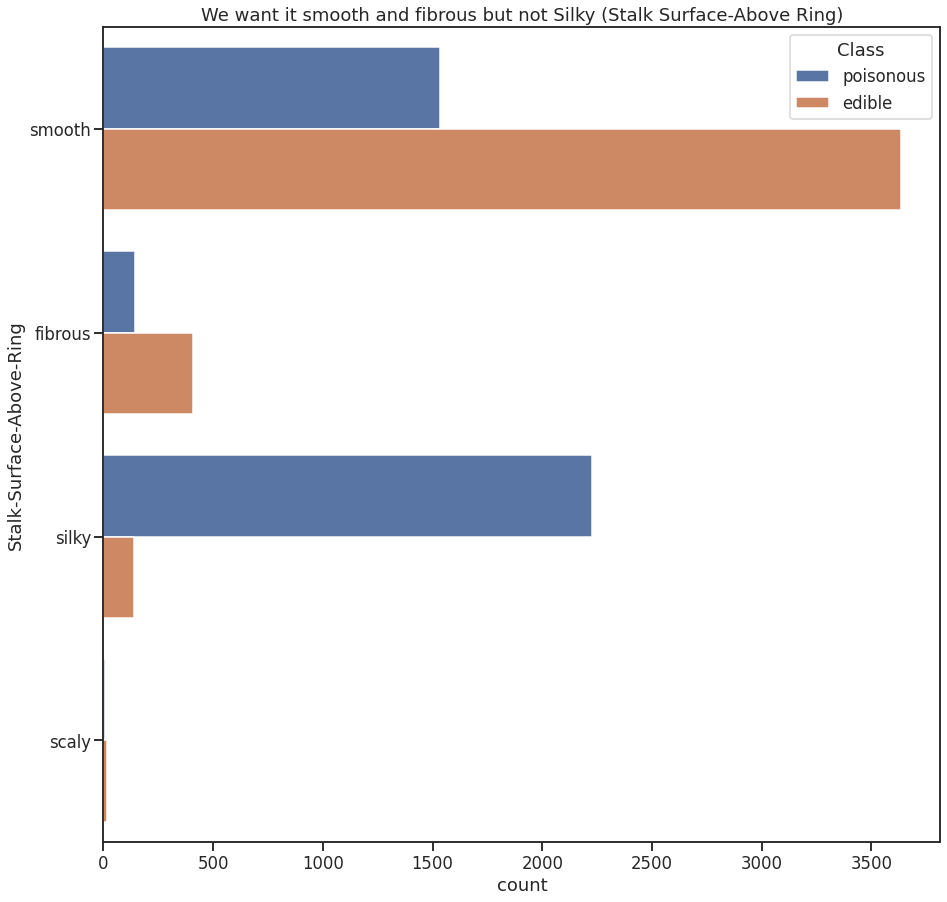

In [21]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Stalk-Surface-Above-Ring', hue='Class')
plt.title("We want it smooth and fibrous but not Silky (Stalk Surface-Above Ring)")

Text(0.5, 1.0, 'Similar results as above stalk surface (Stalk Surface-Below Ring)')

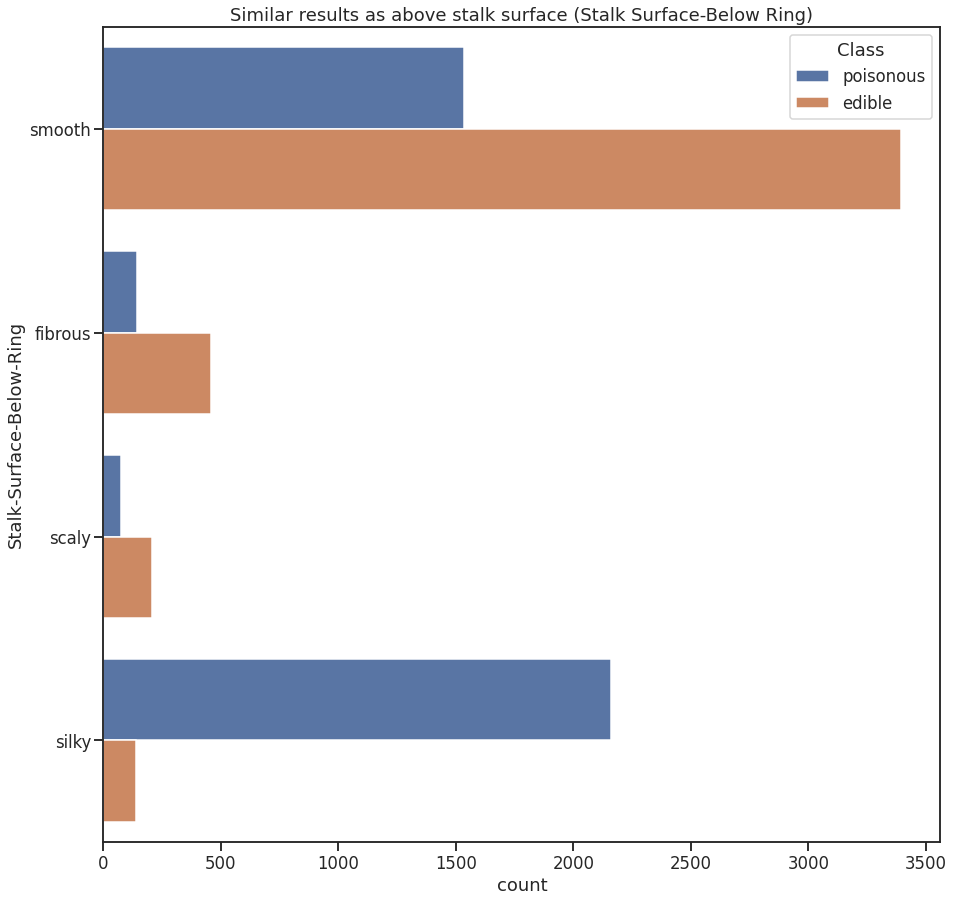

In [22]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Stalk-Surface-Below-Ring', hue='Class')
plt.title("Similar results as above stalk surface (Stalk Surface-Below Ring)")

Text(0.5, 1.0, ' Avoid Buff and Cinnamon (Stalk Color Above Ring)')

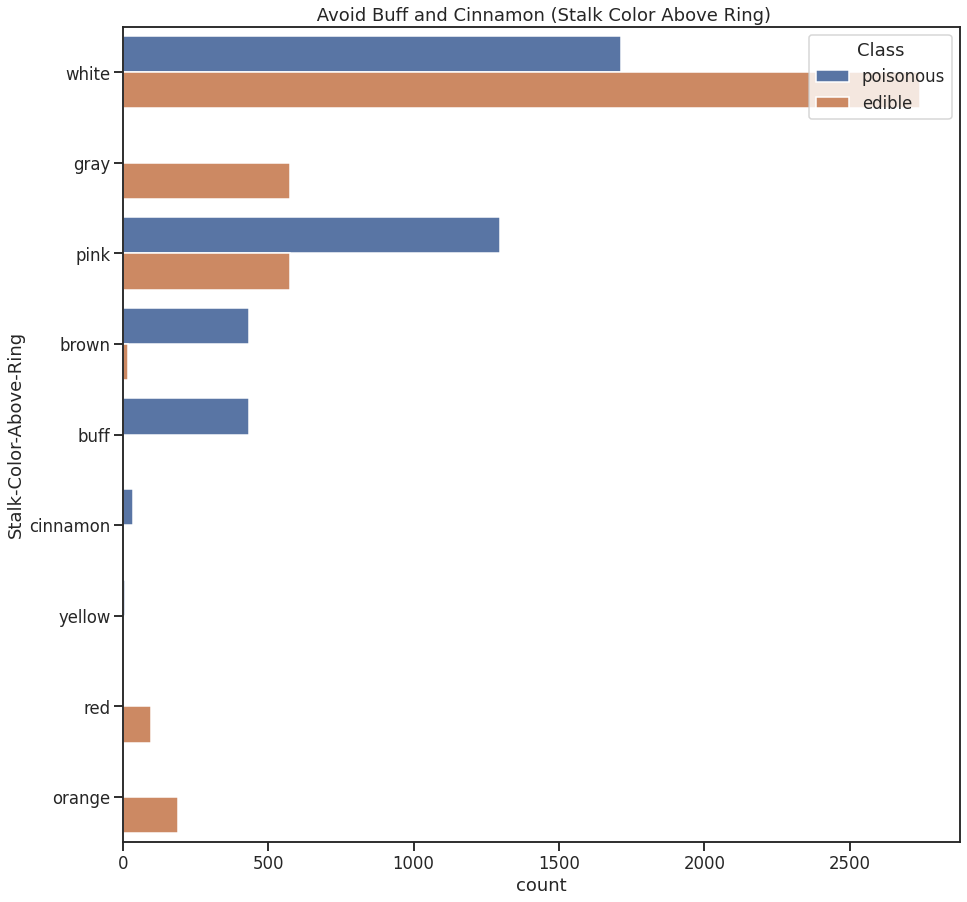

In [23]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Stalk-Color-Above-Ring', hue='Class')
plt.title(" Avoid Buff and Cinnamon (Stalk Color Above Ring)")

Text(0.5, 1.0, 'Avoid Buff, Brown, Pink, Cinnamon, Yellow (Stalk Color-Below-Ring)')

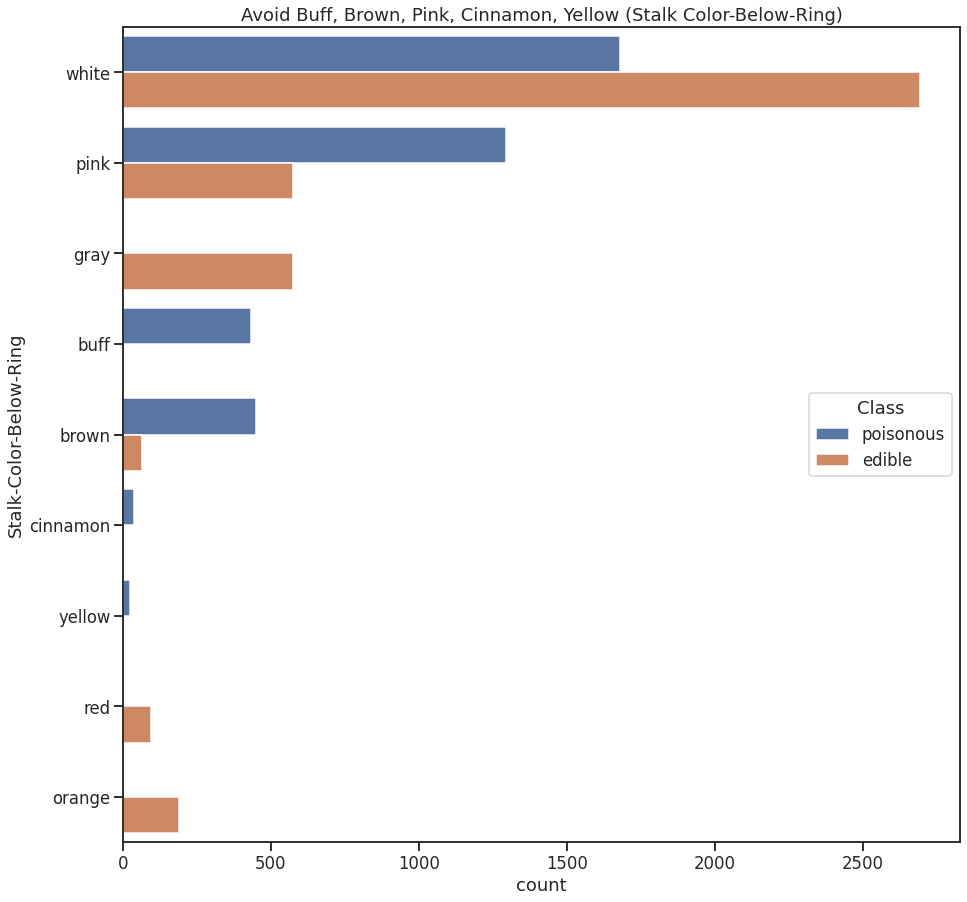

In [24]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Stalk-Color-Below-Ring', hue='Class')
plt.title("Avoid Buff, Brown, Pink, Cinnamon, Yellow (Stalk Color-Below-Ring)")


Text(0.5, 1.0, 'Edible in Meadows (Habitat)')

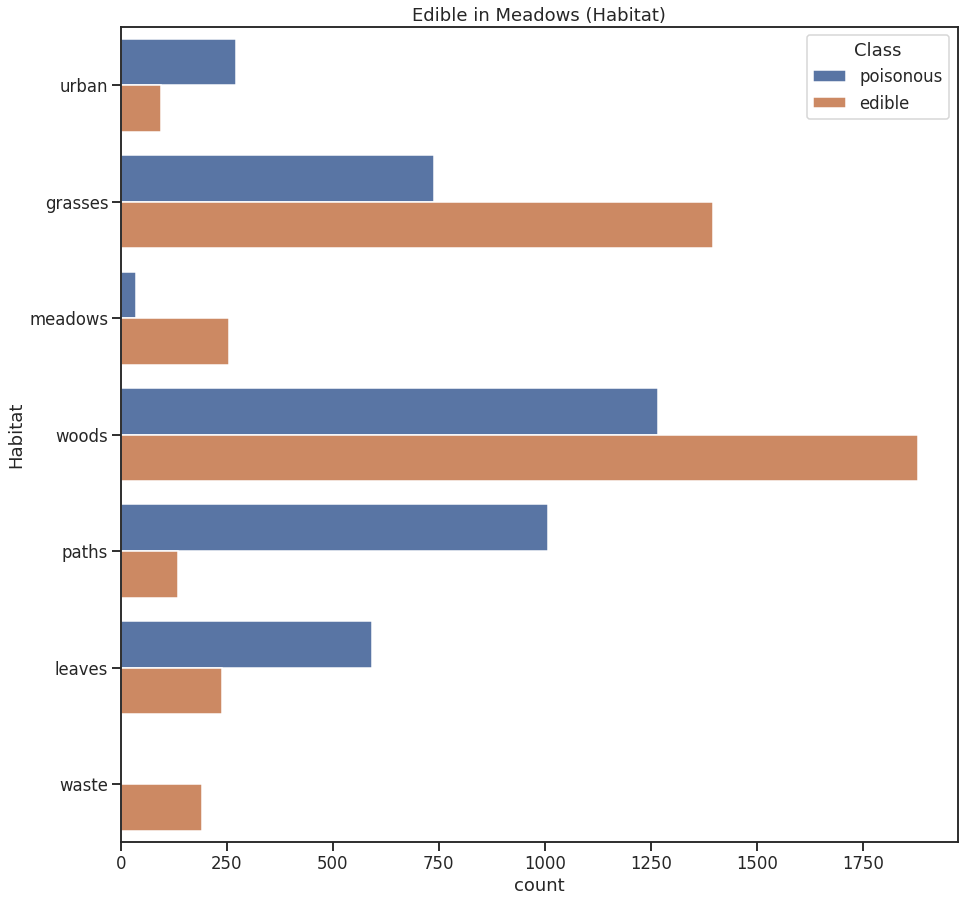

In [25]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Habitat', hue='Class')
plt.title("Edible in Meadows (Habitat)")

Meadows being edible makes the most sense compared to the chart saying that waste should be edible.
There is not varitey so I would not necessarily trust this chart. For percentage of edible to poisonous meadow had around 80%

In [26]:
# see percentages
habitat_edible = pd.crosstab(mushroom['Class'], mushroom['Habitat'], normalize='columns')
habitat_edible

Habitat,grasses,leaves,meadows,paths,urban,waste,woods
Class,,,,,,,
edible,0.653882,0.286747,0.876712,0.118881,0.26087,1.0,0.597205
poisonous,0.346118,0.713253,0.123288,0.881119,0.73913,0.0,0.402795


Text(0.5, 1.0, 'We cannot tell with (Cap Shape)')

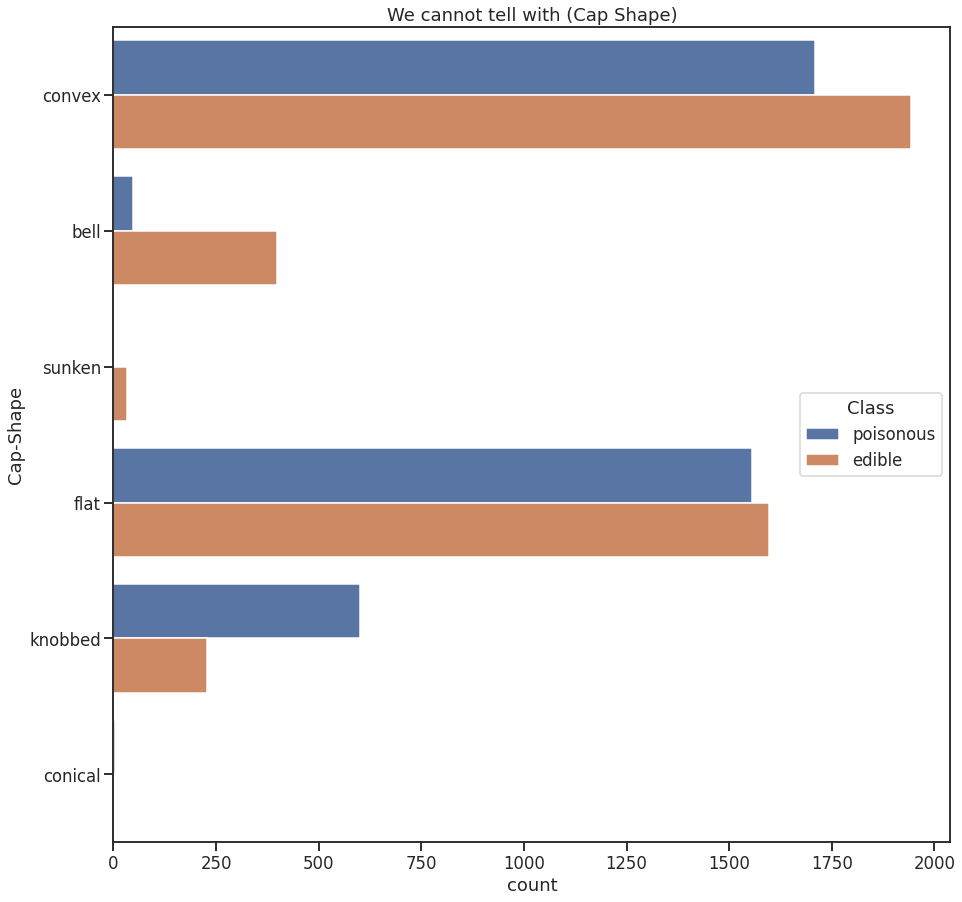

In [27]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Cap-Shape', hue='Class')
plt.title("We cannot tell with (Cap Shape)")


Text(0.5, 1.0, 'We cannot tell with (Cap-Color)')

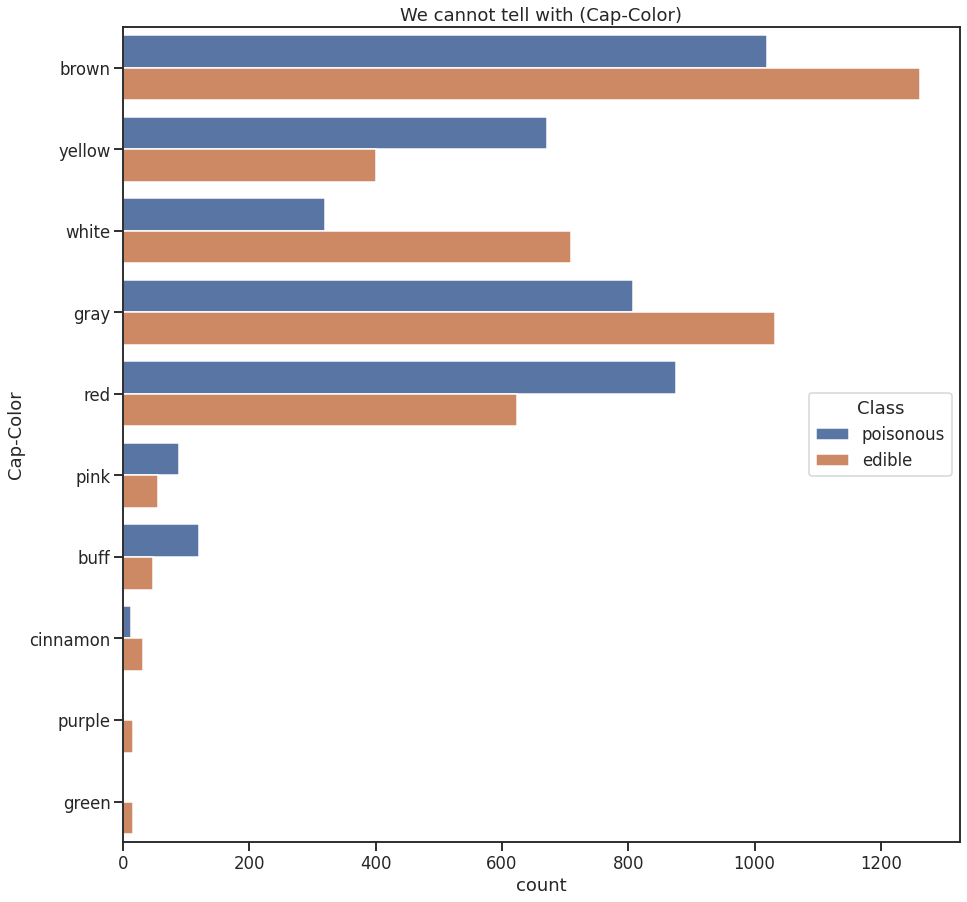

In [28]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Cap-Color', hue='Class')
plt.title("We cannot tell with (Cap-Color)")

## Evaluation

From seeing the difference in association strengths, I think it makes most sense
that weak associations show some variability, whereas stronger associations show more immediate and cold cut
variance (lowest variance); which makes some sense

* need to go back and add some interpretation for graphs
* For evaluating we should use our juedgement in discerning whether there was ample variability to provide a strong argument and whether
conclusions made sense such as seeing habitat near waste mushrooms being edible was concerning

In [29]:
# make a matrix for all cramers value for all column relationshipos

mushroom_col = mushroom.columns.tolist()
mushroom_col
cramers_corr = pd.DataFrame()

for outer_col in mushroom_col:
    adj_cramer_val_list = []
    for inner_col in mushroom_col:
        contingency_table = pd.crosstab(mushroom[outer_col], mushroom[inner_col])
        adj_cramer_val_list.append(get_adjusted_cramers_v(contingency_table))
    cramers_corr[outer_col] = adj_cramer_val_list

cramers_corr

,Class,Cap-Shape,Cap-Surface,Cap-Color,Bruises,Odor,Gill-Attachment,Gill-Spacing,Gill-Size,Gill-Color,...,Stalk-Surface-Above-Ring,Stalk-Surface-Below-Ring,Stalk-Color-Above-Ring,Stalk-Color-Below-Ring,Veil-Color,Ring-Number,Ring-Type,Spore-Print-Color,Population,Habitat
0,0.999753,0.243590,0.195739,0.214389,0.503003,0.970520,0.127366,0.346648,0.539272,0.680438,...,0.589013,0.575930,0.523683,0.513519,0.151748,0.211894,0.602381,0.753543,0.486072,0.439297
1,0.243590,1.000000,0.202771,0.167369,0.255785,0.244387,0.155311,0.075144,0.345952,0.232307,...,0.158707,0.110291,0.212603,0.167764,0.223716,0.195092,0.206557,0.249703,0.240743,0.270321
2,0.195739,0.202771,1.000000,0.222881,0.132208,0.236453,0.208963,0.336680,0.276988,0.255338,...,0.143102,0.168331,0.250418,0.255457,0.132487,0.097074,0.223841,0.231517,0.261004,0.249301
3,0.214389,0.167369,0.222881,1.000000,0.216545,0.330787,0.244544,0.395038,0.469280,0.280314,...,0.255830,0.319177,0.274338,0.277074,0.146521,0.335689,0.557066,0.285254,0.303433,0.324847
4,0.503003,0.255785,0.132208,0.216545,0.999746,0.661285,0.135727,0.297786,0.370334,0.650178,...,0.575491,0.567000,0.482595,0.492274,0.132162,0.072057,0.770493,0.611539,0.300956,0.529997
5,0.970520,0.244387,0.236453,0.330787,0.661285,1.000000,0.260337,0.427672,0.760155,0.389000,...,0.415987,0.507018,0.449356,0.445827,0.099593,0.741793,0.696370,0.395789,0.374352,0.369000
6,0.127366,0.155311,0.208963,0.244544,0.135727,0.260337,0.997533,0.068986,0.107238,0.782565,...,0.091930,0.122815,0.977100,0.977100,0.954531,0.204071,0.250266,0.830236,0.409225,0.433686
7,0.346648,0.075144,0.336680,0.395038,0.297786,0.427672,0.068986,0.999542,0.105970,0.324785,...,0.439360,0.416844,0.398883,0.373004,0.096607,0.237830,0.291445,0.308507,0.673051,0.539934
8,0.539272,0.345952,0.276988,0.469280,0.370334,0.760155,0.107238,0.105970,0.999712,0.783160,...,0.169415,0.150197,0.365034,0.345986,0.111999,0.193051,0.570026,0.662270,0.516927,0.498823
9,0.680438,0.232307,0.255338,0.280314,0.650178,0.389000,0.782565,0.324785,0.783160,1.000000,...,0.352347,0.376954,0.420499,0.416627,0.453971,0.443696,0.517690,0.484592,0.424183,0.457428


In [30]:
cramers_corr.index = mushroom_col
cramers_corr

,Class,Cap-Shape,Cap-Surface,Cap-Color,Bruises,Odor,Gill-Attachment,Gill-Spacing,Gill-Size,Gill-Color,...,Stalk-Surface-Above-Ring,Stalk-Surface-Below-Ring,Stalk-Color-Above-Ring,Stalk-Color-Below-Ring,Veil-Color,Ring-Number,Ring-Type,Spore-Print-Color,Population,Habitat
Class,0.999753,0.243590,0.195739,0.214389,0.503003,0.970520,0.127366,0.346648,0.539272,0.680438,...,0.589013,0.575930,0.523683,0.513519,0.151748,0.211894,0.602381,0.753543,0.486072,0.439297
Cap-Shape,0.243590,1.000000,0.202771,0.167369,0.255785,0.244387,0.155311,0.075144,0.345952,0.232307,...,0.158707,0.110291,0.212603,0.167764,0.223716,0.195092,0.206557,0.249703,0.240743,0.270321
Cap-Surface,0.195739,0.202771,1.000000,0.222881,0.132208,0.236453,0.208963,0.336680,0.276988,0.255338,...,0.143102,0.168331,0.250418,0.255457,0.132487,0.097074,0.223841,0.231517,0.261004,0.249301
Cap-Color,0.214389,0.167369,0.222881,1.000000,0.216545,0.330787,0.244544,0.395038,0.469280,0.280314,...,0.255830,0.319177,0.274338,0.277074,0.146521,0.335689,0.557066,0.285254,0.303433,0.324847
Bruises,0.503003,0.255785,0.132208,0.216545,0.999746,0.661285,0.135727,0.297786,0.370334,0.650178,...,0.575491,0.567000,0.482595,0.492274,0.132162,0.072057,0.770493,0.611539,0.300956,0.529997
Odor,0.970520,0.244387,0.236453,0.330787,0.661285,1.000000,0.260337,0.427672,0.760155,0.389000,...,0.415987,0.507018,0.449356,0.445827,0.099593,0.741793,0.696370,0.395789,0.374352,0.369000
Gill-Attachment,0.127366,0.155311,0.208963,0.244544,0.135727,0.260337,0.997533,0.068986,0.107238,0.782565,...,0.091930,0.122815,0.977100,0.977100,0.954531,0.204071,0.250266,0.830236,0.409225,0.433686
Gill-Spacing,0.346648,0.075144,0.336680,0.395038,0.297786,0.427672,0.068986,0.999542,0.105970,0.324785,...,0.439360,0.416844,0.398883,0.373004,0.096607,0.237830,0.291445,0.308507,0.673051,0.539934
Gill-Size,0.539272,0.345952,0.276988,0.469280,0.370334,0.760155,0.107238,0.105970,0.999712,0.783160,...,0.169415,0.150197,0.365034,0.345986,0.111999,0.193051,0.570026,0.662270,0.516927,0.498823
Gill-Color,0.680438,0.232307,0.255338,0.280314,0.650178,0.389000,0.782565,0.324785,0.783160,1.000000,...,0.352347,0.376954,0.420499,0.416627,0.453971,0.443696,0.517690,0.484592,0.424183,0.457428


Because this is not using correlation and this using an adjusted variation of Cramers V we do not see
a diagonal of 1s down the matrix, but we see nearly 1 values.
We will next make a heat map for interesting visual.


Text(0.5, 1.0, 'Adjusted Cramers V Heatmap')

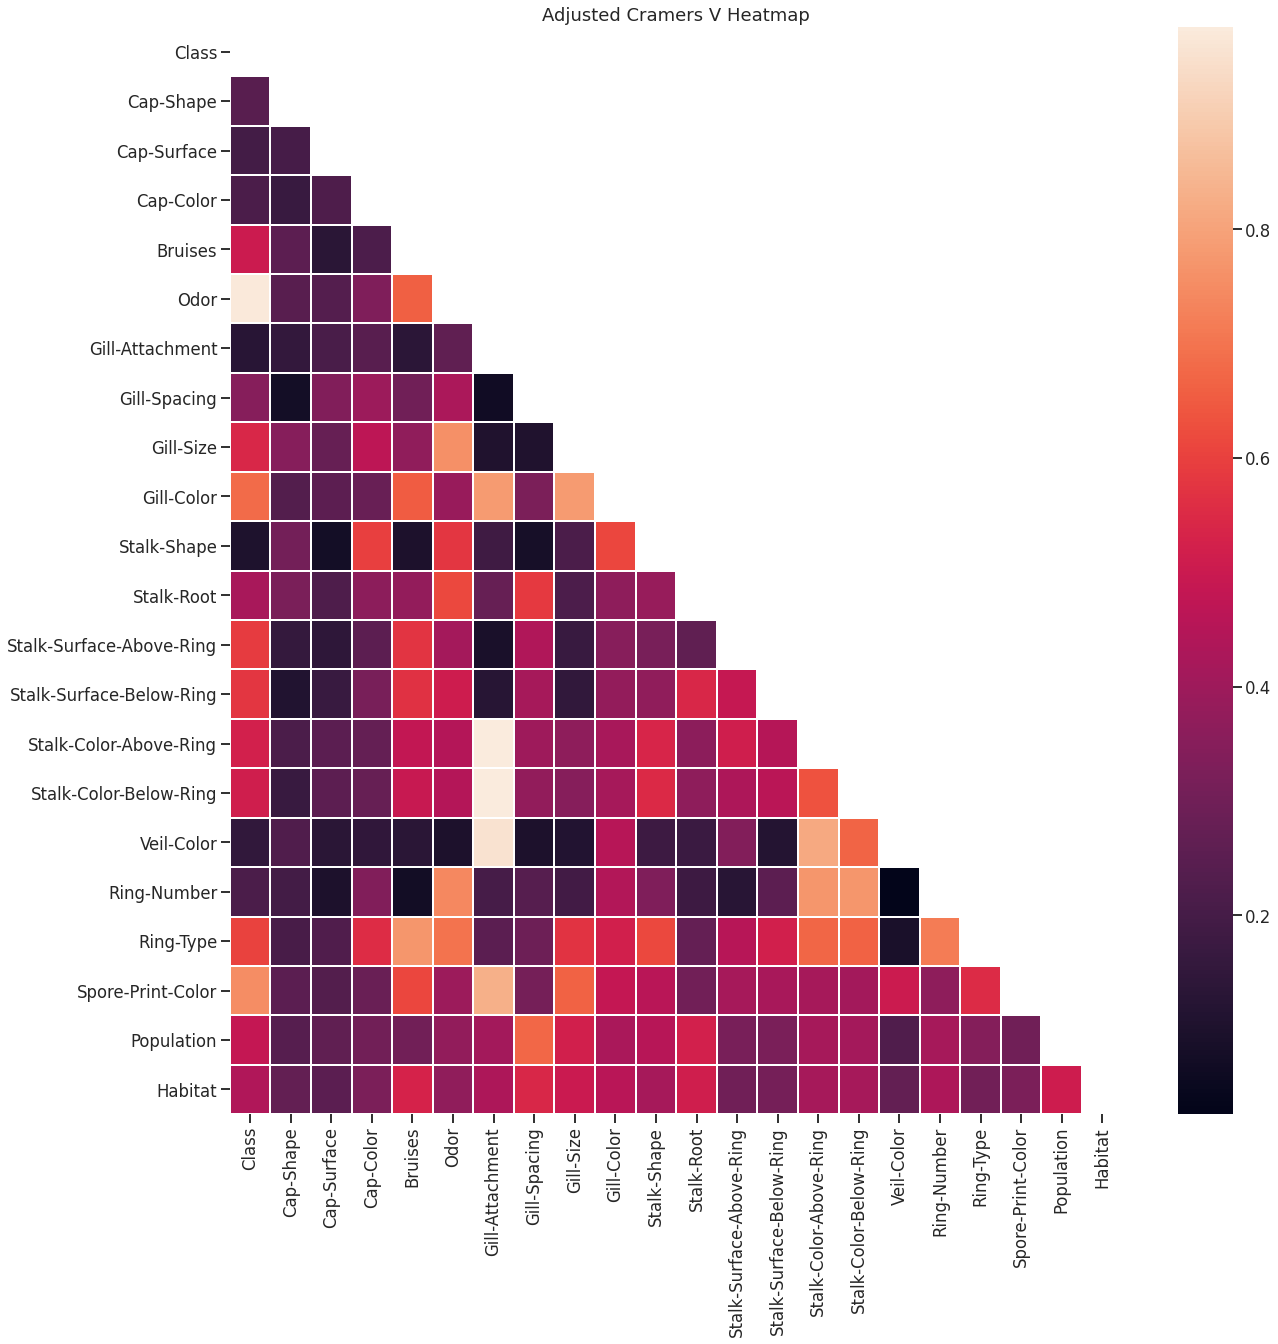

In [31]:
mask = np.zeros_like(cramers_corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20,20))
sns.heatmap(cramers_corr, linewidth=0.2, mask=mask)
plt.title('Adjusted Cramers V Heatmap')

## Evaluation
* It appears from this heat map that odor has strongest association with class.
* Also Gill Attachment has strong association with Veil Color, Stalk-Colors above and below the Ring

## Stat questions (with better visualizations)
* Determine what features are strong with habitat
* Determine what features are strong with cap-color

In [59]:
# Retrieve cramers corr of edibility relations and order them. Also remove edibility with itself
habitat_cramers_corr = cramers_corr['Habitat'].sort_values(ascending=False)
habitat_cramers_corr.drop('Habitat', inplace=True)

In [98]:
habitat_cramers_corr
habitat_df = pd.DataFrame({'features':habitat_cramers_corr.index,'cramers_corr':habitat_cramers_corr}, index=None)
habitat_df.reset_index(inplace=True)
habitat_df.drop('index', axis=1, inplace=True)
habitat_df

,features,cramers_corr
0,Gill-Spacing,0.539934
1,Bruises,0.529997
2,Stalk-Root,0.514765
3,Population,0.506619
4,Gill-Size,0.498823
5,Gill-Color,0.457428
6,Class,0.439297
7,Gill-Attachment,0.433686
8,Ring-Number,0.431630
9,Stalk-Color-Above-Ring,0.417838


In [99]:
# get associated strengths for more interpretatbilitty
habitat_corr_strengths = [assoc_strengths[0] if val > 0.5 else
                          assoc_strengths[1] if val > 0.3 else
                          assoc_strengths[2] if val > 0.1 else
                          assoc_strengths[3] for val in habitat_cramers_corr]
habitat_df.insert(2, 'strength', habitat_corr_strengths)
habitat_df

,features,cramers_corr,strength
0,Gill-Spacing,0.539934,Strong
1,Bruises,0.529997,Strong
2,Stalk-Root,0.514765,Strong
3,Population,0.506619,Strong
4,Gill-Size,0.498823,Moderate
5,Gill-Color,0.457428,Moderate
6,Class,0.439297,Moderate
7,Gill-Attachment,0.433686,Moderate
8,Ring-Number,0.431630,Moderate
9,Stalk-Color-Above-Ring,0.417838,Moderate


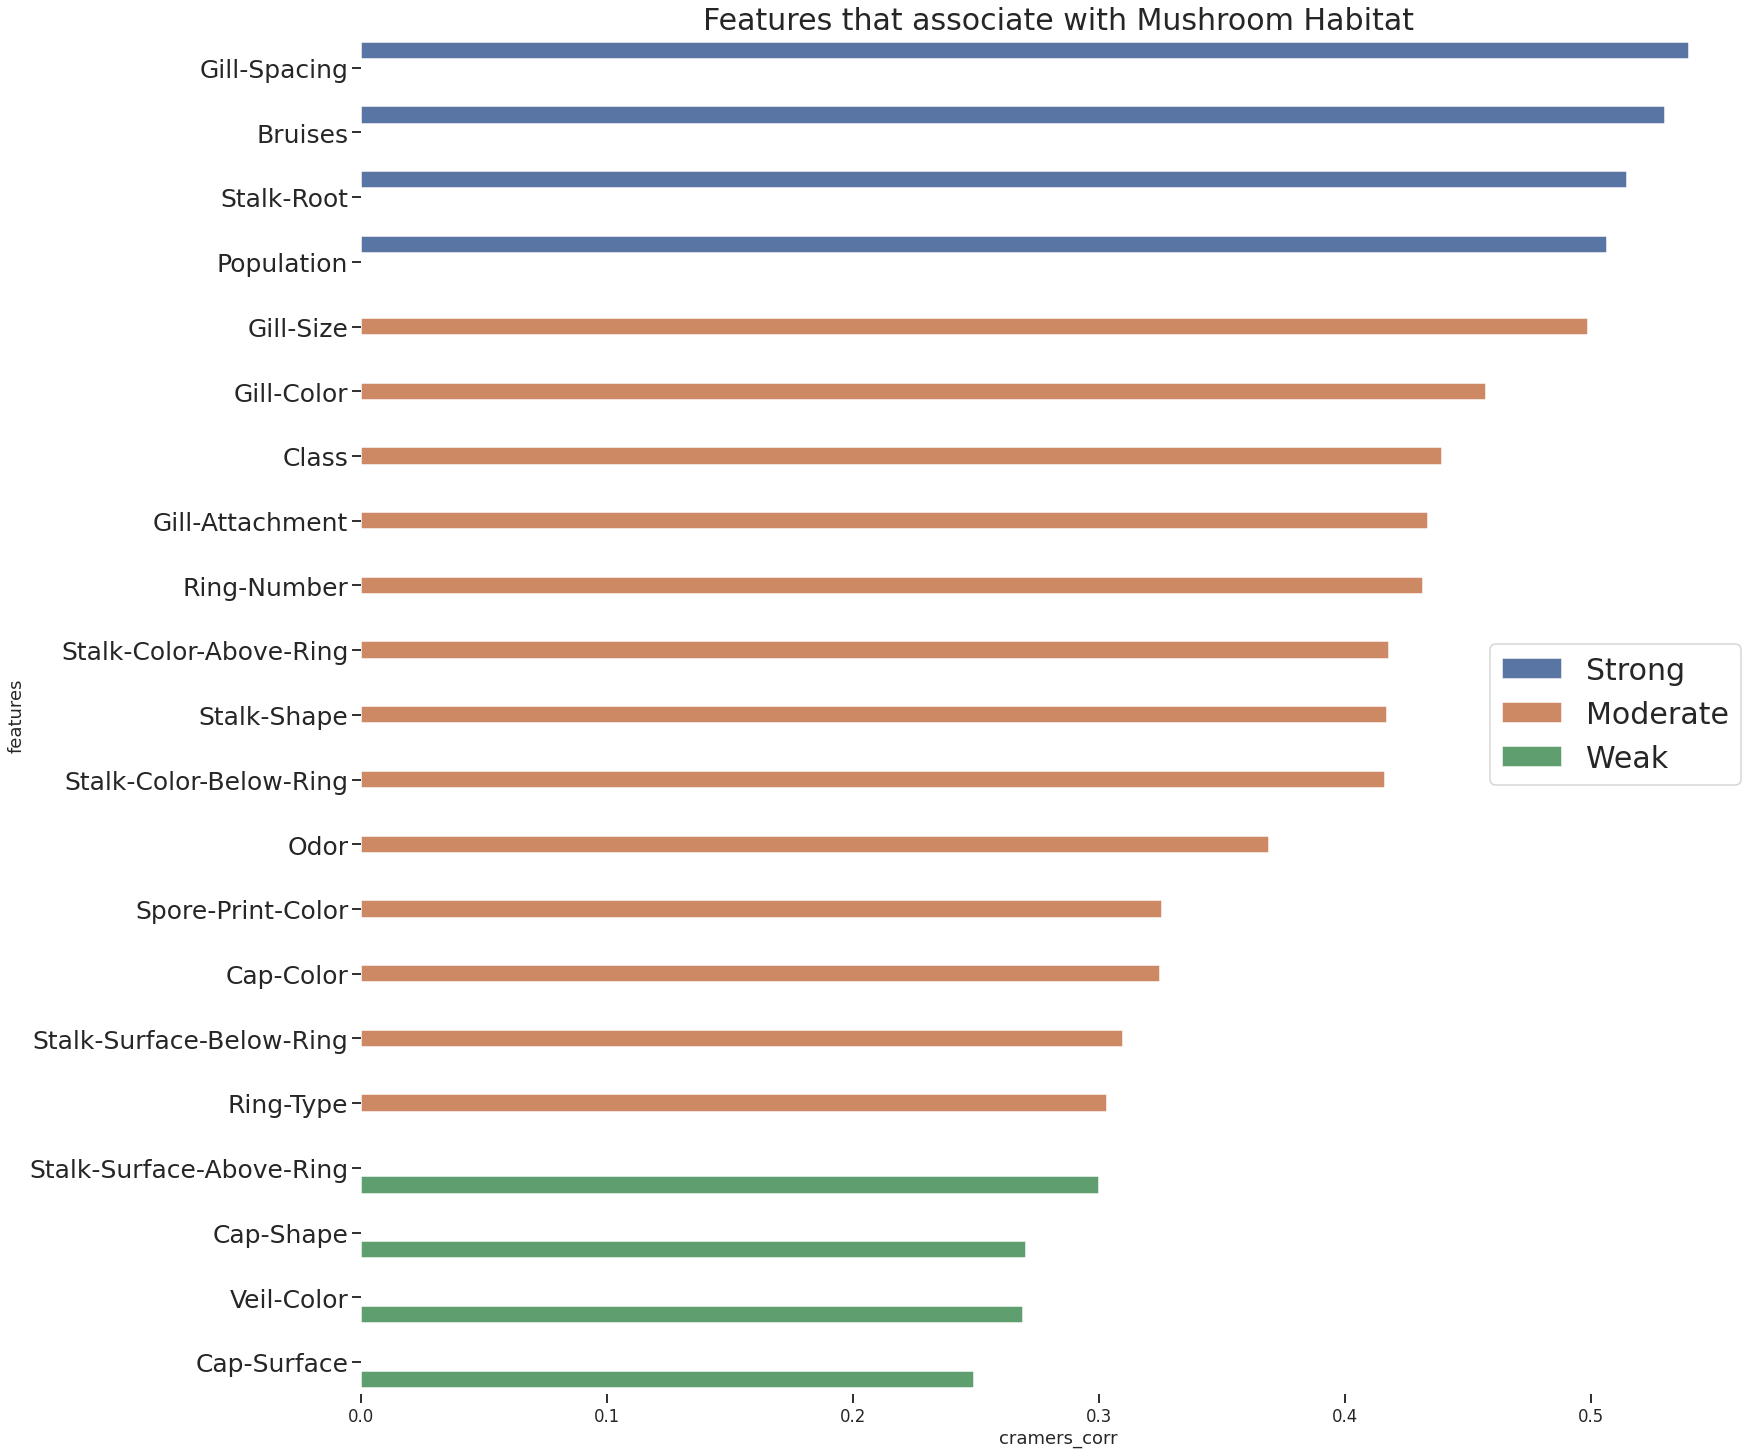

In [100]:
plt.figure(figsize=(25,25))
sns.barplot(data=habitat_df, y='features', x='cramers_corr', hue='strength')
sns.despine(left=True, bottom=True)
plt.title('Features that associate with Mushroom Habitat', fontsize=30)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)

Text(0.5, 1.0, 'Most Crowded Spacing in Grassy')

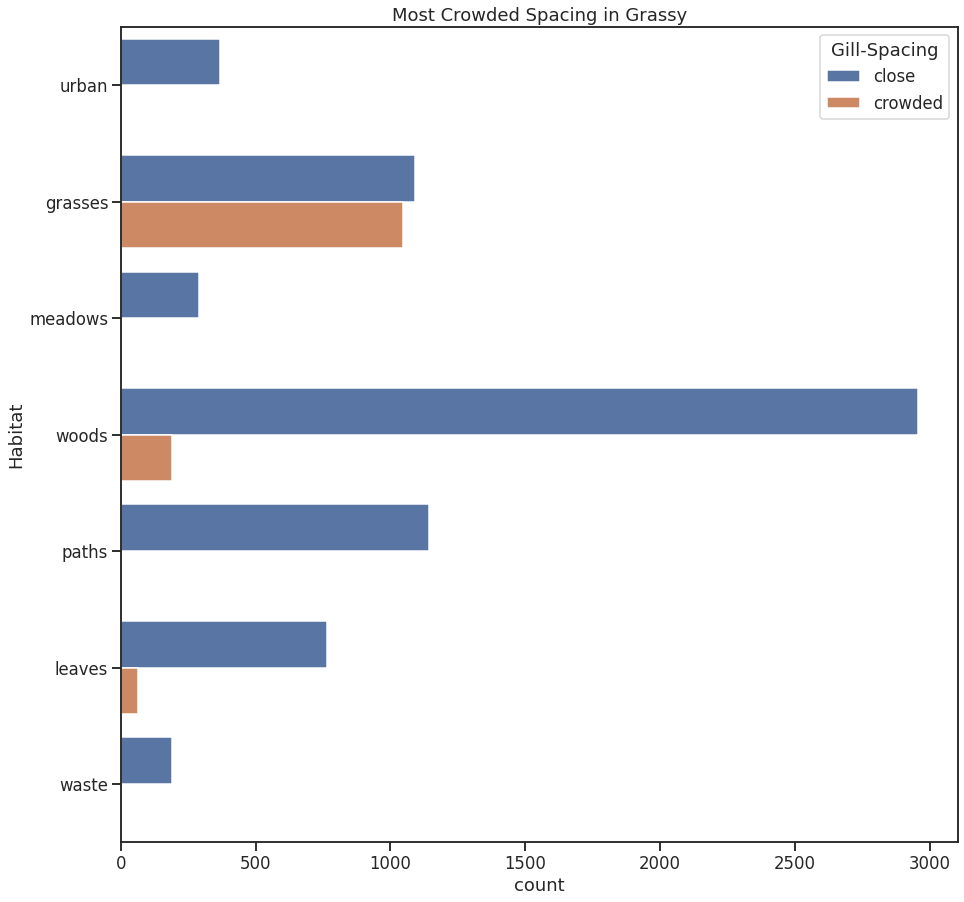

In [107]:

plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Habitat', hue='Gill-Spacing')
plt.title("Most Crowded Spacing in Grassy")

Seems like grassy habitats show most variation or number of mushrooms identified with crowded; this dataset shows
that crowded gill-spacing is not that common in other habitats labelled except those in grassy areas.
All other habitats show a majority of mushrooms hainv gill-spacing closed


Text(0.5, 1.0, 'Brusing in different Habitats')

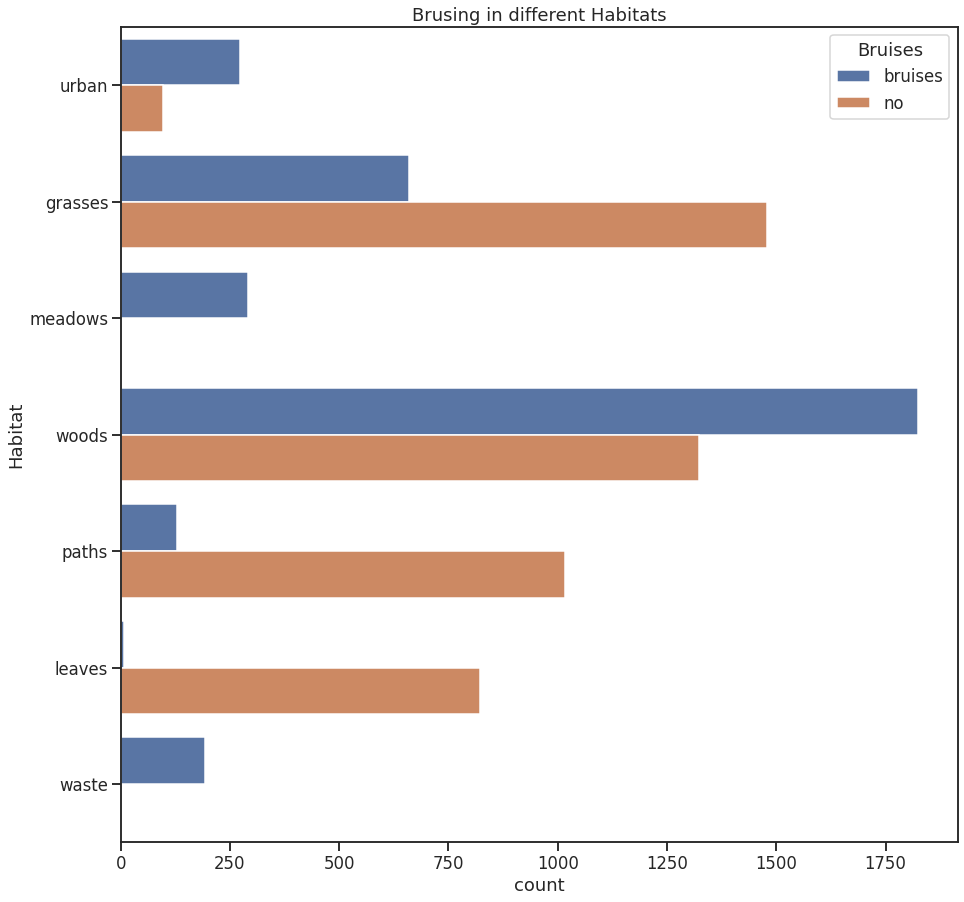

In [108]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Habitat', hue='Bruises')
plt.title("Brusing in different Habitats")

More variety here, and it went agains my assumption with number of mushrooms and bruising; I thought there would be
more instance of brusing in mushrooms but it seems relatively balanced.
Areas in grassy, paths, and leaves tend to have mushrooms with no bruising; whereas wooded, urban, waste areas have
mushroom with bruising.
Also note that mushrooms often bruise to release chemicals or molecules; such as pychoactive ones bruise psilocin

Text(0.5, 1.0, 'Population in different Habitats')

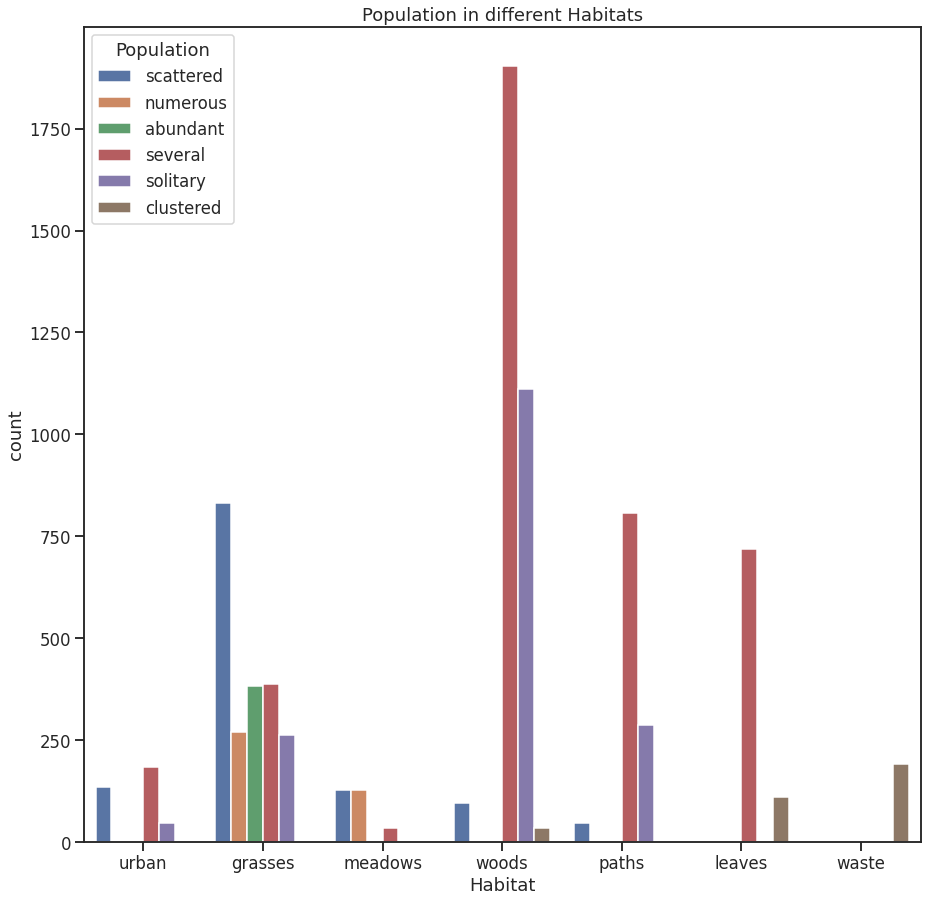

In [112]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, x='Habitat', hue='Population')
plt.title("Population in different Habitats")

Lot of variety in grassy area, but mainly scattered it says.
Waste habitats are clustered
Woody, Paths, Leaves are mostly scattered or solitary
Meadows are often scattered or numerous
